In [2]:
setwd('/import/DB/workdir/cd40/')

In [ ]:
library(Seurat)
MI = readRDS('/import/194.data/data//singledata/after_rename.rds')
Idents(MI) = 'orig.ident'
MI7d = subset(MI,idents = c('MI7d'))
CD.KO7d = Read10X_h5('./1.CellRanger/CD_KO_7d/filtered_feature_bc_matrix.h5')
CD.KO7d = CreateSeuratObject(CD.KO7d,project = 'CD.KO7d')

Warning message:
"package 'Seurat' was built under R version 4.2.3"
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject



In [ ]:
single.ob=merge(MI7d,CD.KO7d)

In [ ]:
immune.combined = single.ob
immune.combined[["percent.mt"]] <- PercentageFeatureSet(immune.combined,pattern = "^mt-")
VlnPlot(immune.combined, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3,pt.size = 0,group.by="orig.ident")
library(ggplot2)

#ggsave('figure1.pdf',height =  4,width = 6)

In [ ]:


Idents(immune.combined) = 'orig.ident'

plot1 <- FeatureScatter(immune.combined, 
                        feature1 = "nCount_RNA", 
                        feature2 = "percent.mt")
plot2 <- FeatureScatter(immune.combined, 
                        feature1 = "nCount_RNA", 
                        feature2 = "nFeature_RNA")
plot1 + plot2

#ggsave('scatter.pdf',,width = 13)

immune.combined <-   subset(immune.combined, subset = nFeature_RNA > 500 & nFeature_RNA < 5000 & percent.mt < 20)

VlnPlot(immune.combined, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3,pt.size = 0,group.by="orig.ident")

#ggsave('figure1-1.pdf',height =  4,width = 6)

library(DoubletFinder)
library(tidyverse)
library(Seurat)
library(patchwork)

In [ ]:
immune.combined <-NormalizeData(immune.combined)
immune.combined <- ScaleData(immune.combined,feature=rownames(immune.combined), verbose = FALSE)
immune.combined <- FindVariableFeatures(object = immune.combined,selection.method = 'vst', nfeatures = 2000)
immune.combined <- RunPCA(immune.combined,  features = VariableFeatures(object = immune.combined) ,verbose = FALSE)
immune.combined <- RunUMAP(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- RunTSNE(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindNeighbors(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindClusters(immune.combined)

In [ ]:
H9 = immune.combined

In [ ]:
paramSweep = function (seu, PCs = 1:20, sct = FALSE, num.cores = 1) 
{
    require(Seurat)
    require(fields)
    require(parallel)
    pK <- c(5e-04, 0.001, 0.005, seq(0.01, 0.3, by = 0.01))
    pN <- seq(0.05, 0.3, by = 0.05)
    min.cells <- round(nrow(seu@meta.data)/(1 - 0.05) - nrow(seu@meta.data))
    pK.test <- round(pK * min.cells)
    pK <- pK[which(pK.test >= 1)]
    orig.commands <- seu@commands
    if (nrow(seu@meta.data) > 10000) {
        real.cells <- rownames(seu@meta.data)[sample(1:nrow(seu@meta.data), 
            10000, replace = FALSE)]
        data <- seu@assays$RNA@counts[, real.cells]
        n.real.cells <- ncol(data)
    }
    if (nrow(seu@meta.data) <= 10000) {
        real.cells <- rownames(seu@meta.data)
        data <- seu@assays$RNA@counts
        n.real.cells <- ncol(data)
    }
    if (num.cores > 1) {
        require(parallel)
        cl <- makeCluster(num.cores)
        output2 <- mclapply(as.list(1:length(pN)), FUN = parallel_paramSweep, 
            n.real.cells, real.cells, pK, pN, data, orig.commands, 
            PCs, sct, mc.cores = num.cores)
        stopCluster(cl)
    }
    else {
        output2 <- lapply(as.list(1:length(pN)), FUN = parallel_paramSweep, 
            n.real.cells, real.cells, pK, pN, data, orig.commands, 
            PCs, sct)
    }
    sweep.res.list <- list()
    list.ind <- 0
    for (i in 1:length(output2)) {
        for (j in 1:length(output2[[i]])) {
            list.ind <- list.ind + 1
            sweep.res.list[[list.ind]] <- output2[[i]][[j]]
        }
    }
    name.vec <- NULL
    for (j in 1:length(pN)) {
        name.vec <- c(name.vec, paste("pN", pN[j], "pK", pK, 
            sep = "_"))
    }
    names(sweep.res.list) <- name.vec
    return(sweep.res.list)
}

In [ ]:
sweep.res.list_kidney <- paramSweep(H9, PCs = 1:20, sct = FALSE)

In [ ]:
sweep.stats_kidney <- summarizeSweep(sweep.res.list_kidney, GT = FALSE)
bcmvn_kidney <- find.pK(sweep.stats_kidney)

In [ ]:
pK_bcmvn <- bcmvn_kidney$pK[which.max(bcmvn_kidney$BCmetric)] %>% as.character() %>% as.numeric()

In [ ]:
DoubletRate = ncol(H9)*8*1e-7

In [ ]:
DoubletRate

In [ ]:
homotypic.prop <- modelHomotypic(H9$orig.ident)

In [ ]:
nExp_poi <- round(DoubletRate*ncol(H9)) 
nExp_poi.adj <- round(nExp_poi*(1-homotypic.prop))

In [ ]:
doubletFinder = function (seu, PCs, pN = 0.25, pK, nExp, reuse.pANN = FALSE, 
    sct = FALSE, annotations = NULL) 
{
    require(Seurat)
    require(fields)
    require(KernSmooth)
    if (reuse.pANN != FALSE) {
        pANN.old <- seu@meta.data[, reuse.pANN]
        classifications <- rep("Singlet", length(pANN.old))
        classifications[order(pANN.old, decreasing = TRUE)[1:nExp]] <- "Doublet"
        seu@meta.data[, paste("DF.classifications", pN, pK, nExp, 
            sep = "_")] <- classifications
        return(seu)
    }
    if (reuse.pANN == FALSE) {
        real.cells <- rownames(seu@meta.data)
        data <- seu@assays$RNA@counts[, real.cells]
        n_real.cells <- length(real.cells)
        n_doublets <- round(n_real.cells/(1 - pN) - n_real.cells)
        print(paste("Creating", n_doublets, "artificial doublets...", 
            sep = " "))
        real.cells1 <- sample(real.cells, n_doublets, replace = TRUE)
        real.cells2 <- sample(real.cells, n_doublets, replace = TRUE)
        doublets <- (data[, real.cells1] + data[, real.cells2])/2
        colnames(doublets) <- paste("X", 1:n_doublets, sep = "")
        data_wdoublets <- cbind(data, doublets)
        if (!is.null(annotations)) {
            stopifnot(typeof(annotations) == "character")
            stopifnot(length(annotations) == length(Cells(seu)))
            stopifnot(!any(is.na(annotations)))
            annotations <- factor(annotations)
            names(annotations) <- Cells(seu)
            doublet_types1 <- annotations[real.cells1]
            doublet_types2 <- annotations[real.cells2]
        }
        orig.commands <- seu@commands
        if (sct == FALSE) {
            print("Creating Seurat object...")
            seu_wdoublets <- CreateSeuratObject(counts = data_wdoublets)
            print("Normalizing Seurat object...")
            seu_wdoublets <- NormalizeData(seu_wdoublets, normalization.method = orig.commands$NormalizeData.RNA@params$normalization.method, 
                scale.factor = orig.commands$NormalizeData.RNA@params$scale.factor, 
                margin = orig.commands$NormalizeData.RNA@params$margin)
            print("Finding variable genes...")
            seu_wdoublets <- FindVariableFeatures(seu_wdoublets, 
                selection.method = orig.commands$FindVariableFeatures.RNA$selection.method, 
                loess.span = orig.commands$FindVariableFeatures.RNA$loess.span, 
                clip.max = orig.commands$FindVariableFeatures.RNA$clip.max, 
                mean.function = orig.commands$FindVariableFeatures.RNA$mean.function, 
                dispersion.function = orig.commands$FindVariableFeatures.RNA$dispersion.function, 
                num.bin = orig.commands$FindVariableFeatures.RNA$num.bin, 
                binning.method = orig.commands$FindVariableFeatures.RNA$binning.method, 
                nfeatures = orig.commands$FindVariableFeatures.RNA$nfeatures, 
                mean.cutoff = orig.commands$FindVariableFeatures.RNA$mean.cutoff, 
                dispersion.cutoff = orig.commands$FindVariableFeatures.RNA$dispersion.cutoff)
            print("Scaling data...")
            seu_wdoublets <- ScaleData(seu_wdoublets, features = orig.commands$ScaleData.RNA$features, 
                model.use = orig.commands$ScaleData.RNA$model.use, 
                do.scale = orig.commands$ScaleData.RNA$do.scale, 
                do.center = orig.commands$ScaleData.RNA$do.center, 
                scale.max = orig.commands$ScaleData.RNA$scale.max, 
                block.size = orig.commands$ScaleData.RNA$block.size, 
                min.cells.to.block = orig.commands$ScaleData.RNA$min.cells.to.block)
            print("Running PCA...")
            seu_wdoublets <- RunPCA(seu_wdoublets, features = orig.commands$ScaleData.RNA$features, 
                npcs = length(PCs), rev.pca = orig.commands$RunPCA.RNA$rev.pca, 
                weight.by.var = orig.commands$RunPCA.RNA$weight.by.var, 
                verbose = FALSE)
            pca.coord <- seu_wdoublets@reductions$pca@cell.embeddings[, 
                PCs]
            cell.names <- rownames(seu_wdoublets@meta.data)
            nCells <- length(cell.names)
            rm(seu_wdoublets)
            gc()
        }
        if (sct == TRUE) {
            require(sctransform)
            print("Creating Seurat object...")
            seu_wdoublets <- CreateSeuratObject(counts = data_wdoublets)
            print("Running SCTransform...")
            seu_wdoublets <- SCTransform(seu_wdoublets)
            print("Running PCA...")
            seu_wdoublets <- RunPCA(seu_wdoublets, npcs = length(PCs))
            pca.coord <- seu_wdoublets@reductions$pca@cell.embeddings[, 
                PCs]
            cell.names <- rownames(seu_wdoublets@meta.data)
            nCells <- length(cell.names)
            rm(seu_wdoublets)
            gc()
        }
        print("Calculating PC distance matrix...")
        dist.mat <- fields::rdist(pca.coord)
        print("Computing pANN...")
        pANN <- as.data.frame(matrix(0L, nrow = n_real.cells, 
            ncol = 1))
        if (!is.null(annotations)) {
            neighbor_types <- as.data.frame(matrix(0L, nrow = n_real.cells, 
                ncol = length(levels(doublet_types1))))
        }
        rownames(pANN) <- real.cells
        colnames(pANN) <- "pANN"
        k <- round(nCells * pK)
        for (i in 1:n_real.cells) {
            neighbors <- order(dist.mat[, i])
            neighbors <- neighbors[2:(k + 1)]
            pANN$pANN[i] <- length(which(neighbors > n_real.cells))/k
            if (!is.null(annotations)) {
                for (ct in unique(annotations)) {
                  neighbors_that_are_doublets = neighbors[neighbors > 
                    n_real.cells]
                  if (length(neighbors_that_are_doublets) > 0) {
                    neighbor_types[i, ] <- table(doublet_types1[neighbors_that_are_doublets - 
                      n_real.cells]) + table(doublet_types2[neighbors_that_are_doublets - 
                      n_real.cells])
                    neighbor_types[i, ] <- neighbor_types[i, 
                      ]/sum(neighbor_types[i, ])
                  }
                  else {
                    neighbor_types[i, ] <- NA
                  }
                }
            }
        }
        print("Classifying doublets..")
        classifications <- rep("Singlet", n_real.cells)
        classifications[order(pANN$pANN[1:n_real.cells], decreasing = TRUE)[1:nExp]] <- "Doublet"
        seu@meta.data[, paste("pANN", pN, pK, nExp, sep = "_")] <- pANN[rownames(seu@meta.data), 
            1]
        seu@meta.data[, paste("DF.classifications", pN, pK, nExp, 
            sep = "_")] <- classifications
        if (!is.null(annotations)) {
            colnames(neighbor_types) = levels(doublet_types1)
            for (ct in levels(doublet_types1)) {
                seu@meta.data[, paste("DF.doublet.contributors", 
                  pN, pK, nExp, ct, sep = "_")] <- neighbor_types[, 
                  ct]
            }
        }
        return(seu)
    }
}

In [ ]:
scRNA <- doubletFinder(H9, PCs = 1:20, pN = 0.25, pK = pK_bcmvn, 
                          nExp = nExp_poi.adj, reuse.pANN = F, sct = F)

In [ ]:
colnames(scRNA@meta.data)

In [ ]:
DimPlot(scRNA, reduction = "umap", group.by = "DF.classifications_0.25_0.005_100")

In [ ]:
#ggsave('figure2.pdf',height =  4,width = 5)

In [ ]:
immune.combined = subset(scRNA, subset = DF.classifications_0.25_0.005_100  != 'Doublet')

In [ ]:
table(immune.combined$orig.ident)

In [ ]:
ifnb.list <- SplitObject(immune.combined, split.by = "orig.ident")

testAB.anchors <- FindIntegrationAnchors(object.list = ifnb.list, dims = 1:20)
testAB.integrated <- IntegrateData(anchorset = testAB.anchors, dims = 1:20)

DefaultAssay(testAB.integrated) <- "integrated"
# Run the standard workflow for visualization and clustering
testAB.integrated <- ScaleData(testAB.integrated, features = rownames(testAB.integrated))
testAB.integrated <- RunPCA(testAB.integrated, npcs = 50, verbose = FALSE)
testAB.integrated <- FindNeighbors(testAB.integrated, dims = 1:30)
testAB.integrated <- FindClusters(testAB.integrated, resolution = 0.3)
testAB.integrated <- RunUMAP(testAB.integrated, dims = 1:30)
testAB.integrated <- RunTSNE(testAB.integrated, dims = 1:30)

immune.combined = testAB.integrated

In [ ]:
#saveRDS(immune.combined,file = 'before_rename.rds')

In [ ]:
library(Seurat)

In [ ]:
#scRNA = readRDS('./before_rename.rds')

In [ ]:
scRNA = immune.combined
DimPlot(scRNA, reduction = "umap", group.by = "orig.ident")

In [ ]:
library(ggplot2)

In [ ]:
#ggsave('figure3.pdf',height =  4,width = 5)

In [ ]:
immune.combined = scRNA

In [ ]:
DimPlot(immune.combined, reduction = "umap", split.by  = "orig.ident",ncol = 2)

In [ ]:
#ggsave('figure4.pdf',height =  8,width = 12)

In [ ]:
scRNA = immune.combined

In [ ]:
library(Seurat) ##
library(SingleR)
library(ggplot2)
library(reshape2)
mouseImmu  = get(load('/import/DB/SingleR_ref/ref_Mouse_all.RData'))
pbmc_for_SingleR <- GetAssayData(scRNA, slot="data") ##获取标准化矩阵
clusters=scRNA@meta.data$seurat_clusters
pred.mouseImmu <- SingleR(test = pbmc_for_SingleR, ref = mouseImmu, labels = mouseImmu$label.main,
 method = "cluster", clusters = clusters, 
 assay.type.test = "logcounts", assay.type.ref = "logcounts")
celltype = data.frame(ClusterID=rownames(pred.mouseImmu), celltype=pred.mouseImmu$labels, stringsAsFactors = FALSE)

In [ ]:
scRNA@meta.data$celltype = "NA"
# 赋值
for(i in 1:nrow(celltype)){
  scRNA@meta.data[which(scRNA@meta.data$seurat_clusters == celltype$ClusterID[i]),'celltype'] <- celltype$celltype[i]}

In [ ]:
#scRNA = readRDS('./after_rename.rds')

In [ ]:
scRNA

In [ ]:
library(Seurat)

In [ ]:
scRNA@meta.data$celltype = gsub('Monocytes','Myloeid',scRNA@meta.data$celltype)

In [ ]:
DimPlot(scRNA, group.by="celltype", label=T, label.size=5, reduction='umap')

In [ ]:
Idents(scRNA) = 'seurat_clusters'

In [ ]:
DimPlot(scRNA, group.by="seurat_clusters", label=T, label.size=5, reduction='umap')

In [ ]:
library(ggplot2)

In [ ]:
#ggsave('figure5.pdf',height =  8,width = 9)

In [ ]:
DimPlot(scRNA, group.by="seurat_clusters", label=T, label.size=5, reduction='umap')

In [ ]:
ggsave('figure6.pdf',height =  8,width = 9)

In [ ]:
table(scRNA$seurat_clusters)

In [ ]:
Idents(scRNA) = 'seurat_clusters'

In [ ]:
scedata = scRNA

In [ ]:
Idents(scRNA) = 'seurat_clusters'

In [ ]:
DotPlot(scRNA,features = c('Plac8','Chil3','Ly6c2'))

In [ ]:
Idents(scRNA) ='celltype'

scedata = scRNA
table(scedata$orig.ident)#查看各组细胞数
prop.table(table(Idents(scedata)))
table(Idents(scedata), scedata$orig.ident)#各组不同细胞群细胞数
Cellratio <- prop.table(table(Idents(scedata), scedata$orig.ident), margin = 2)#计算各组样本不同细胞群比例
Cellratio <- as.data.frame(Cellratio)

Cellratio$Var2 = factor(Cellratio$Var2,levels = c('CD.KO7d', 'MI7d'))

allcolour=c("#DC143C","#0000FF","#20B2AA","#FFA500","#9370DB","#98FB98","#F08080","#1E90FF","#7CFC00","#FFFF00",
            "#808000","#FF00FF","#FA8072","#7B68EE","#9400D3","#800080","#A0522D","#D2B48C","#D2691E","#87CEEB","#40E0D0","#5F9EA0",
            "#FF1493","#0000CD","#008B8B","#FFE4B5","#8A2BE2","#228B22","#E9967A","#4682B4","#32CD32","#F0E68C","#FFFFE0","#EE82EE",
            "#FF6347","#6A5ACD","#9932CC","#8B008B","#8B4513","#DEB887")
library(ggplot2)
ggplot(Cellratio) + 
  geom_bar(aes(x =Var2, y= Freq, fill = Var1),stat = "identity",width = 0.7,size = 0.5,colour = '#222222')+ 
  theme_classic() +
  labs(x='Sample',y = 'Ratio')+
  scale_fill_manual(values = allcolour)+
  theme(panel.border = element_rect(fill=NA,color="black", size=0.5, linetype="solid"))

library(Seurat)
library(ggplot2)
library(dplyr)
library(ggalluvial)

In [ ]:
saveRDS(scRNA,file = 'after_rename.rds')

In [ ]:
options(repr.plot.height = 6,rpr.plot.wdith = 5)

In [ ]:
ggplot(Cellratio, aes(x =Var2, y= Freq, fill = Var1,
                  stratum=Var1, alluvium=Var1)) +
  geom_col(width = 0.5, color='black')+
  geom_flow(width=0.5,alpha=0.4, knot.pos=0.5)+ # 参数knot.pos设置为0.5使连接为曲线面积，就像常见的桑基图
  theme_classic() +
  labs(x='Sample',y = 'Ratio')+
  scale_fill_manual(values = allcolour) + theme(axis.text.x = element_text(angle = 45, 
 vjust = 0.5, hjust=0.5))

In [35]:
ggsave('figure6.pdf',height =  5,width = 4)

In [36]:
scRNA  = readRDS('./after_rename.rds')

In [72]:
Idents(scRNA) = 'seurat_clusters'

In [38]:
Idents(scRNA) = 'celltype'

sce.markers <- FindAllMarkers(object = scRNA, only.pos = TRUE, 
                              min.pct = 0.25, 
                              thresh.use = 0.25)
 

library(dplyr) 
# 不同seurat版本的 avg_logFC 不一样 
top5 <- sce.markers %>% group_by(cluster) %>% top_n(5, avg_log2FC)



### https://zhuanlan.zhihu.com/p/573321126
## https://zhuanlan.zhihu.com/p/594345612


Calculating cluster Granulocytes

Calculating cluster Macrophages

Calculating cluster Monocytes

Calculating cluster Endothelial cells

Calculating cluster Fibroblasts

Calculating cluster B cells

Calculating cluster Dendritic cells

Calculating cluster NK cells



In [39]:
# options(repr.plot.height = 9,repr.plot.width = 7)

#  DotPlot(scRNA, features = unique(top5$gene) ,
#  assay='RNA' ) + coord_flip()+ theme(axis.text.x = element_text(angle = 45, 
#  vjust = 0.5, hjust=0.5))

In [40]:
ggsave('figure7.pdf',height =  9,width = 8)

In [41]:
library('clusterProfiler')



Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProf

In [42]:
library(dplyr) 
top50 <- sce.markers %>% group_by(cluster) %>% top_n(50, avg_log2FC)

group <- data.frame(gene=top50$gene,
                    group=top50$cluster)

Gene_ID <- bitr(top50$gene, fromType="SYMBOL", 
            toType="ENTREZID", 
            OrgDb="org.Mm.eg.db")
data  <- merge(Gene_ID,group,by.x='SYMBOL',by.y='gene')
data_GO <- compareCluster(
  ENTREZID~group, 
  data=data, 
  fun="enrichGO", 
  OrgDb="org.Mm.eg.db",
  ont = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff = 0.05,
  qvalueCutoff = 0.05,
  readable = TRUE
)





'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(top50$gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Mm.eg.db"):
"1.13% of input gene IDs are fail to map..."


In [43]:
top50

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
5.079555e-219,4.142258,0.942,0.444,1.015911e-215,Granulocytes,Acod1
1.213617e-204,5.732509,0.912,0.397,2.427234e-201,Granulocytes,S100a9
6.907320e-196,3.196815,0.877,0.303,1.381464e-192,Granulocytes,Il1r2
8.001212e-193,3.632872,0.962,0.687,1.600242e-189,Granulocytes,Il1b
2.365397e-186,3.306032,0.935,0.609,4.730794e-183,Granulocytes,Clec4e
3.885452e-179,5.374141,0.867,0.395,7.770904e-176,Granulocytes,S100a8
1.363625e-176,3.030512,0.774,0.187,2.727249e-173,Granulocytes,Mmp9
8.016430e-168,3.071327,0.817,0.336,1.603286e-164,Granulocytes,Hdc
6.624674e-167,3.143156,0.957,0.784,1.324935e-163,Granulocytes,Antxr2


In [44]:
data_GO_sim <- simplify(data_GO, 
                        cutoff=0.5, 
                        by="p.adjust", 
                        select_fun=min)

write.csv(data_GO_sim@compareClusterResult,file = 'enrichment.csv',row.names =F)

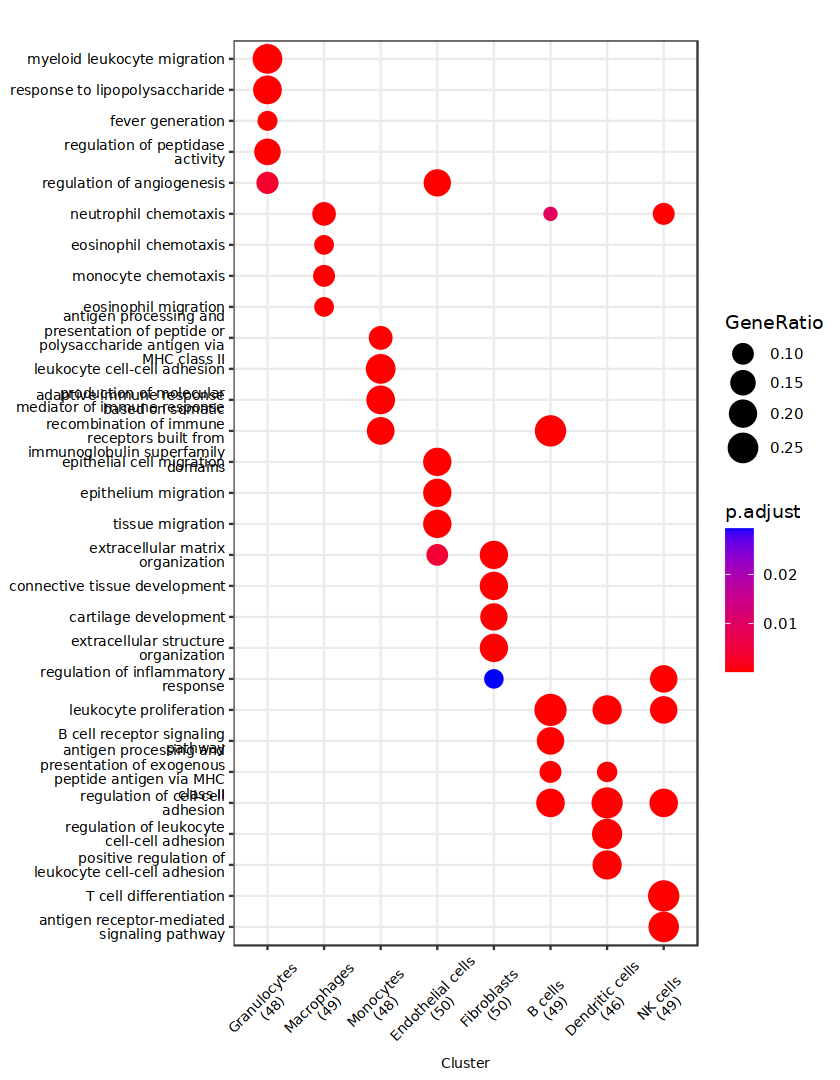

In [45]:
options(repr.plot.height = 9,repr.plot.width = 7)
enrichplot::dotplot(data_GO_sim, showCategory=4,font.size = 8)+ theme(axis.text.x = element_text(angle = 45, 
 vjust = 0.5, hjust=0.5))

In [46]:
ggsave('figure8.pdf',height =  9,width = 8)

In [47]:
saveRDS(scRNA ,file = 'after_rename.rds')

In [48]:
Idents(scRNA) = 'celltype'

In [49]:
meyloid = subset(scRNA,idents = c('Macrophages','Monocytes'))

In [50]:
saveRDS(meyloid ,file = 'meyloid.rds')